In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("BankNote_Authentication_Cleaned.csv")

# Display the first few rows of the data
df.head()

data = df.copy()


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
# Pearson corelation
# Calculate Pearson correlation of each feature with the target variable
corr = data.corr()['class'].drop('class')

corr


variance   -0.735185
skewness   -0.449835
curtosis    0.154376
entropy    -0.033979
Name: class, dtype: float64

In [ ]:
# Higher absolute values of correlation
# indicate stronger relationships with the target variable. Based on this, 
# variance and skewness have stronger relationships with the target compared to curtosis and entropy


In [3]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Splitting the data into features and target
X = data.drop('class', axis=1)
y = data['class']

# Initialize a model
model = LogisticRegression()

# Initialize RFE
rfe = RFE(model, 3)  # Let's start with selecting the top 3 features
fit = rfe.fit(X, y)

# Get the ranking of the features
feature_ranking = pd.Series(fit.ranking_, index=X.columns)

feature_ranking


TypeError: __init__() takes 2 positional arguments but 3 were given

In [4]:
# Correcting the RFE initialization
rfe = RFE(estimator=model, n_features_to_select=3)  # Selecting the top 3 features
fit = rfe.fit(X, y)

# Get the ranking of the features
featureranking = pd.Series(fit.ranking_, index=X.columns)

featureranking


variance    1
skewness    1
curtosis    1
entropy     2
dtype: int32

In [ ]:
# variance, skewness, and curtosis

In [5]:
from sklearn.model_selection import train_test_split

# Select the top 3 features
Xselected = X[['variance', 'skewness', 'curtosis']]

# Splitting the data into training and test sets (80% training, 20% test)
Xtrain, X_test, ytrain, y_test = train_test_split(Xselected, y, test_size=0.20, random_state=42)

Xtrain.shape, X_test.shape


((1078, 3), (270, 3))

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

# Initialize the classifiers
logreg = LogisticRegression()
from sklearn.svm import SVC
svm = SVC(probability=True)  # Enabling probability estimation for ROC AUC
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

classifiers = [('Logistic Regression', logreg), ('SVM', svm), ('Decision Tree', dtree)]

# Dictionary to store results
results = {}

for name, clf in classifiers:
    start_time = time.time()
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Cross validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Predict on test set
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1] if name != 'SVM' else clf.decision_function(X_test)
    
    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    end_time = time.time()
    
    # Store results
    results[name] = {
        'Training Time': end_time - start_time,
        'CV Accuracy Mean': cv_mean,
        'CV Accuracy Std': cv_std,
        'Test Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

results_df = pd.DataFrame(results).T
results_df


,Training Time,CV Accuracy Mean,CV Accuracy Std,Test Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.067849,0.993493,0.007264,0.992593,0.98400,1.0,0.991935,1.000000
SVM,0.237050,0.993493,0.005968,0.988889,0.97619,1.0,0.987952,1.000000
Decision Tree,0.040324,0.985151,0.010339,0.992593,0.98400,1.0,0.991935,0.993197


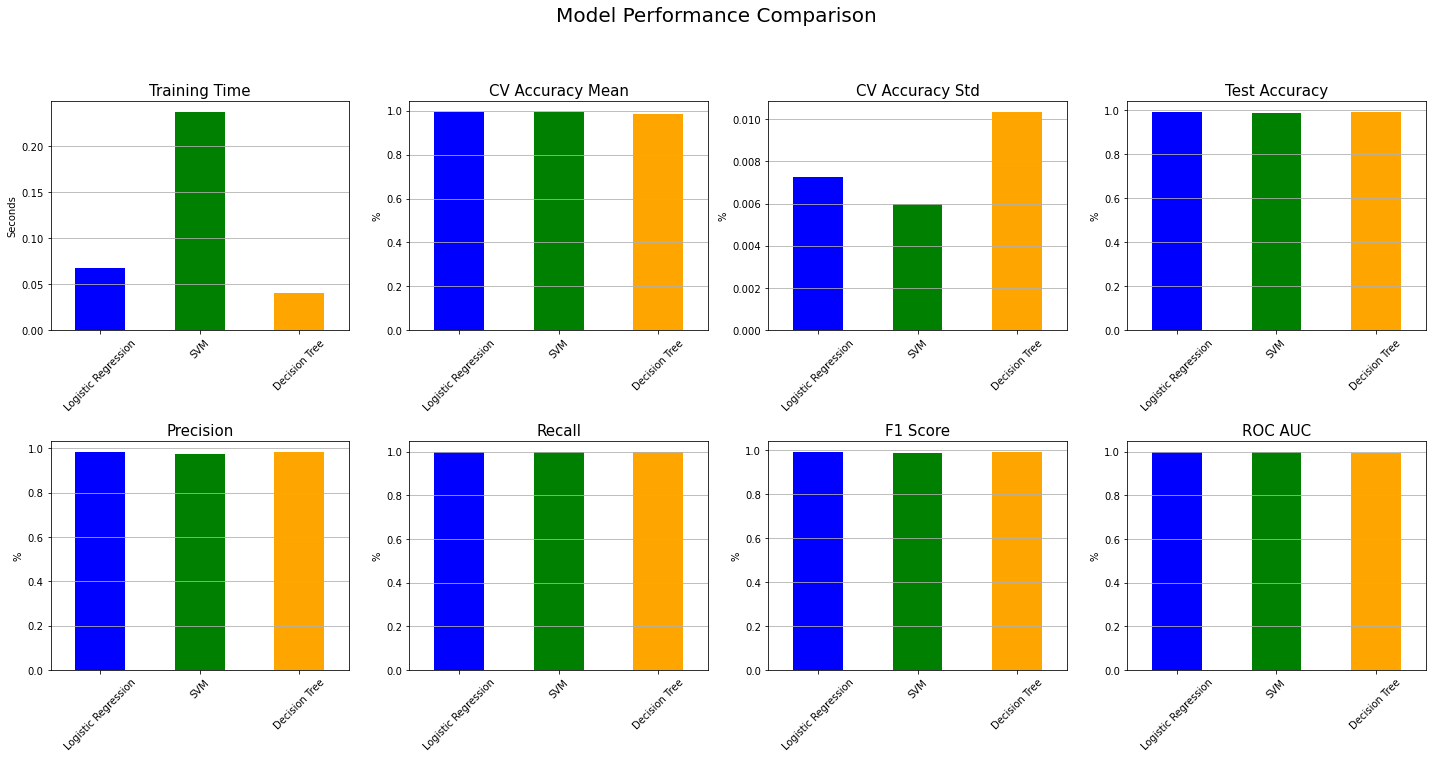

In [8]:
import matplotlib.pyplot as plt

# Setting up the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Model Performance Comparison', fontsize=20, y=1.05)

metrics = ['Training Time', 'CV Accuracy Mean', 'CV Accuracy Std', 'Test Accuracy', 
           'Precision', 'Recall', 'F1 Score', 'ROC AUC']

for ax, metric in zip(axs.ravel(), metrics):
    results_df[metric].plot(kind='bar', ax=ax, color=['blue', 'green', 'orange'])
    ax.set_title(metric, fontsize=15)
    ax.set_ylabel('%' if metric not in ['Training Time'] else 'Seconds')
    ax.set_xlabel('')
    ax.set_xticklabels(results_df.index, rotation=45)
    ax.grid(axis='y')

plt.tight_layout()
plt.show()


In [ ]:
# All three models perform remarkably well on the test data.
# The Logistic Regression and SVM models both achieve very high ROC AUC scores of 100%. 
# The Decision Tree model also achieves a high ROC AUC score of 98.30%. 
# The SVM takes the longest time to train, while the Decision Tree is the quickest.



